In [1]:
from odc.stac import load
from pystac_client import Client
from wofs.classifier import classify
from planetary_computer import sign_url

from wofs.virtualproduct import scale_usgs_collection2
from wofs.filters import eo_filter, terrain_filter, c2_filter
from wofs.constants import NO_DATA
import numpy as np

In [2]:
mspc_catalog = "https://planetarycomputer.microsoft.com/api/stac/v1"
mspc_landsat_collection = "landsat-c2-l2"

# Get a STAC client
client = Client.open(mspc_catalog)

# Tasmanian south west, near Precipitous bluff
bbox = [146.5, -43.6, 146.7, -43.4]

# This image is clear
datetime = "2024-05-10"

# Search for Landsat data
items = list(
    client.search(
        collections=[mspc_landsat_collection],
        bbox=bbox,
        datetime=datetime,
    ).items()
)

print(f"Found {len(items)} items")

Found 1 items


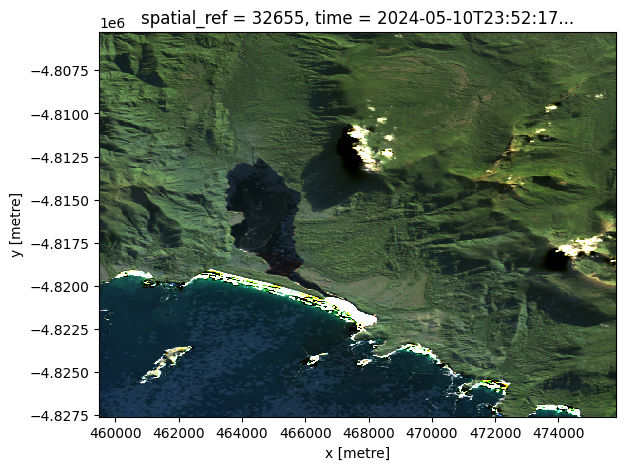

In [3]:
wofs_bands = ["blue", "green", "red", "nir08", "swir16", "swir22"]
wofs_bands_qa = wofs_bands.append("qa_pixel")
data = (
    load(
        items,
        bbox=bbox,
        bands=wofs_bands_qa,
        resolution=30,
        chunks={"x": 2048, "y": 2048},
        patch_url=sign_url,
    )
    .squeeze()
    .load()
)

# plot the scenes so we can pick one
data[["red", "green", "blue"]].to_array().plot.imshow(
    size=5, vmin=7000, vmax=10000)

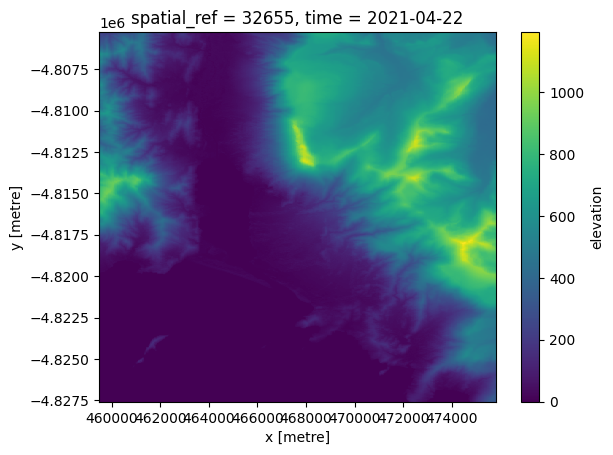

In [4]:
# Load elevation
dem_items = list(
    client.search(
        collections=["cop-dem-glo-30"],
        bbox=bbox,
    ).items()
)

dem = load(dem_items, like=data).squeeze()
dsm = dem.rename({"data": "elevation"})

dsm.elevation.plot.imshow()

/opt/homebrew/lib/python3.11/site-packages/wofs/classifier.py:81: RuntimeWarning: invalid value encountered in divide
  c = (a - b) / (a + b)
/opt/homebrew/lib/python3.11/site-packages/wofs/terrain.py:117: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x, y = tile.dims.keys()


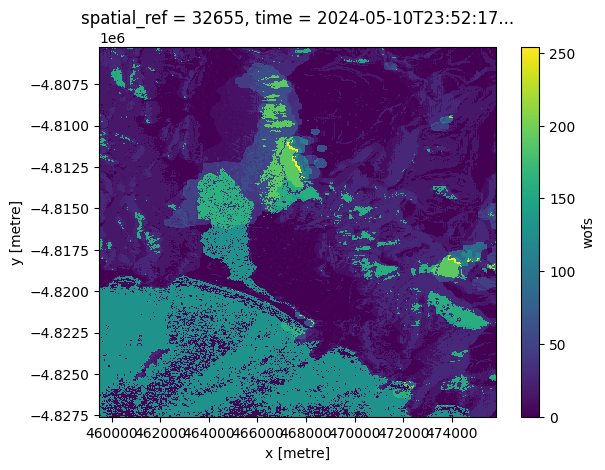

In [5]:
data_scaled = scale_usgs_collection2(data[wofs_bands])

wofs_raw = classify(data_scaled.to_array())

# Set up attrs on the DSM
dsm.attrs["crs"] = data.odc.crs

# Set up the masks and combine them
no_data = ~data.red.where(data.red == 0, NO_DATA).astype(bool)
wofs_masked = (
    wofs_raw
    | eo_filter(data_scaled)
    | terrain_filter(dsm, data, no_data=0, ignore_dsm_no_data=True)
    | c2_filter(data.qa_pixel)
    | no_data
)

# Messy little thing to make any nodata areas ONLY nodata
nodata_set = np.bitwise_and(wofs_masked, NO_DATA) == NO_DATA

# If we don't specifically set the dtype in the following line,
# dask arrays explode to int64s. Make sure it stays a uint8!
wofs_masked.data[nodata_set] = np.array(NO_DATA, dtype="uint8")

data["wofs"] = wofs_masked

data.wofs.plot.imshow()

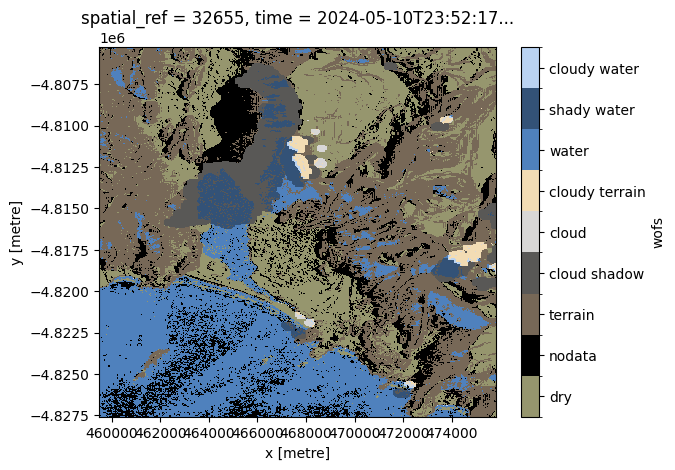

In [6]:
from dea_tools.plotting import plot_wo

plot_wo(data.wofs)